In [1]:
import tensorflow as tf
tf.enable_eager_execution()

import numpy as np
import os
import time
import matplotlib.pyplot as plt

In [2]:
# Read, then decode for py2 compat.
text = open('data.txt', 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print ('Length of text: {} characters'.format(len(text)))

Length of text: 2072753 characters


In [3]:
# The unique characters in the file
vocab = sorted(set(text))
print ('{} unique characters'.format(len(vocab)))

34 unique characters


In [4]:
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

In [5]:
# The maximum length sentence we want for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//seq_length

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
sequences = char_dataset.batch(seq_length+1, drop_remainder = True)

for item in sequences.take(5):
    print(repr(''.join(idx2char[item.numpy()])))

'<music21.note.Note B->\n<music21.chord.Chord D4 F3 B-3>\n<music21.chord.Chord D5 F5 B-5 D6>\n<music21.ch'
'ord.Chord F3 D4 B-3>\n<music21.chord.Chord F5 B-5 D5 D6>\n<music21.chord.Chord D4 B-3 F3>\n<music21.chor'
'd.Chord D5 E-6 F5 B-5>\n<music21.chord.Chord D4 B-3 F3>\n<music21.chord.Chord D6 D5 B-5 F5>\n<music21.ch'
'ord.Chord B-3 D4 F3>\n<music21.chord.Chord F5 D5 B-5 D6>\n<music21.chord.Chord D4 F3 B-3>\n<music21.chor'
'd.Chord D5 B-4 F5 B-5>\n<music21.chord.Chord F3 D3 B-3>\n<music21.note.Note B->\n<music21.chord.Chord B-'


In [6]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [7]:
for input_example, target_example in  dataset.take(1):
    print ('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
    print ('Target data:', repr(''.join(idx2char[target_example.numpy()])))

Input data:  '<music21.note.Note B->\n<music21.chord.Chord D4 F3 B-3>\n<music21.chord.Chord D5 F5 B-5 D6>\n<music21.c'
Target data: 'music21.note.Note B->\n<music21.chord.Chord D4 F3 B-3>\n<music21.chord.Chord D5 F5 B-5 D6>\n<music21.ch'


In [8]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print("Step {:4d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step    0
  input: 12 ('<')
  expected output: 27 ('m')
Step    1
  input: 27 ('m')
  expected output: 33 ('u')
Step    2
  input: 33 ('u')
  expected output: 31 ('s')
Step    3
  input: 31 ('s')
  expected output: 26 ('i')
Step    4
  input: 26 ('i')
  expected output: 22 ('c')


In [9]:
# Batch size
BATCH_SIZE = 256
steps_per_epoch = examples_per_epoch//BATCH_SIZE

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((256, 100), (256, 100)), types: (tf.int64, tf.int64)>

In [10]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [11]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(len(vocab), embedding_dim,
                              batch_input_shape=[BATCH_SIZE, None]))
model.add(tf.keras.layers.CuDNNGRU(rnn_units,
        return_sequences=True,
        recurrent_initializer='glorot_uniform',
        stateful=True))
model.add(tf.keras.layers.Dense(len(vocab)))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (256, None, 256)          8704      
_________________________________________________________________
cu_dnngru (CuDNNGRU)         (256, None, 1024)         3938304   
_________________________________________________________________
dense (Dense)                (256, None, 34)           34850     
Total params: 3,981,858
Trainable params: 3,981,858
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(256, 100, 34) # (batch_size, sequence_length, vocab_size)


In [13]:
def loss(labels, logits):
    return tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits)

model.compile(
    optimizer = tf.train.AdamOptimizer(),
    loss = loss)

In [14]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_music_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_c_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)


In [15]:
EPOCHS=10

# history = model.fit(dataset.repeat(), epochs=EPOCHS, steps_per_epoch=steps_per_epoch, callbacks=[checkpoint_callback])

history = model.fit(dataset.repeat(), epochs=EPOCHS, steps_per_epoch=steps_per_epoch, callbacks=[checkpoint_callback])

Epoch 1/10
80/80 [==============================] - 14s 170ms/step - loss: 1.3489
Epoch 2/10
80/80 [==============================] - 14s 171ms/step - loss: 0.2433
Epoch 3/10
80/80 [==============================] - 14s 170ms/step - loss: 0.2139
Epoch 4/10
80/80 [==============================] - 14s 171ms/step - loss: 0.2028
Epoch 5/10
80/80 [==============================] - 14s 173ms/step - loss: 0.1971
Epoch 6/10
80/80 [==============================] - 14s 172ms/step - loss: 0.1928
Epoch 7/10
80/80 [==============================] - 14s 172ms/step - loss: 0.1905
Epoch 8/10
80/80 [==============================] - 14s 174ms/step - loss: 0.1889
Epoch 9/10
80/80 [==============================] - 14s 175ms/step - loss: 0.1872
Epoch 10/10
80/80 [==============================] - 14s 175ms/step - loss: 0.1860


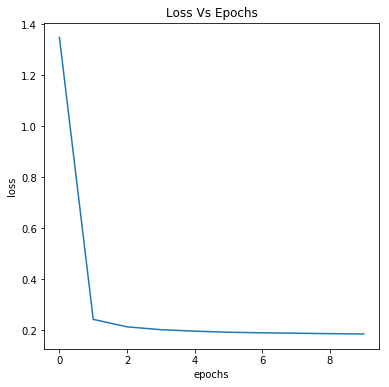

In [16]:
plt.figure(figsize = (6,6))
plt.plot(history.history['loss'])
plt.title('Loss Vs Epochs')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [18]:
checkpoint_dir = './training_music_checkpoints/ckpt_c_10'
# tf.train.latest_checkpoint(checkpoint_dir)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(len(vocab), embedding_dim,
                              batch_input_shape=[1, None]))
model.add(tf.keras.layers.CuDNNGRU(rnn_units,
        return_sequences=True,
        recurrent_initializer='glorot_uniform',
        stateful=True))
model.add(tf.keras.layers.Dense(len(vocab)))

model.load_weights(checkpoint_dir)

model.build(tf.TensorShape([1, None]))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (1, None, 256)            8704      
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (1, None, 1024)           3938304   
_________________________________________________________________
dense_2 (Dense)              (1, None, 34)             34850     
Total params: 3,981,858
Trainable params: 3,981,858
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
def generate_text(model, start_string):
    # Evaluation step (generating text using the learned model)

    # Number of characters to generate
    num_generate = 5000

    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Low temperatures results in more predictable text.
    # Higher temperatures results in more surprising text.
    # Experiment to find the best setting.
    temperature = 1.0

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a multinomial distribution to predict the word returned by the model
        predictions = predictions / temperature
        predicted_id = tf.multinomial(predictions, num_samples=1)[-1,0].numpy()

        # We pass the predicted word as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))


In [23]:
with open('gen.txt', 'w') as f:
    f.write(generate_text(model, start_string=u"<"))